In [135]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.80'

import numpy as np
import jax
import jax.numpy as jnp
import jax_cosmo as jc      # Jax-cosmo lib
import pyccl as ccl         # CCL python      # just to make a plot
import jemupk  as emu  # Jax Emulator of CLASS

In [136]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
import matplotlib.patches as mpatches
mpl.rcParams['font.size'] = 16

# Jemu parameters

In [137]:
import settings_gfpkq_120x20  as st         # configuration file (update 2/June/22)
print(f"(k,z)-grid: {st.nk}x{st.nz}")

(k,z)-grid: 120x20


In [138]:
root_dir = "./"
if st.sigma8:
    print("Using: Omega_cdm, Omega_b, sigma8, ns, h")
    tag='_Omega_sig8_'  + str(st.nk) + "x" + str(st.nz)  
else:
    raise NotImplementedError("non-sigma8 parameter set no more in use")

load_dir = root_dir + '/pknl_components' + st.d_one_plus+tag

Using: Omega_cdm, Omega_b, sigma8, ns, h


In [139]:
# load GP material
gp_factory = emu.GP_factory.load_gps(directory=load_dir,gp_names=["Pklin0"])

In [140]:
assert len(gp_factory["pl"]) == st.nk

In [141]:
assert emu.GP_factory.done

# Define a cosmology parameter set

In [142]:
h_emu = 0.6774 
Omega_c_emu = 0.2589
Omega_b_emu = 0.0486
sigma8_emu = 0.8159
n_s_emu = 0.9667


In [143]:
#jax-cosmo cosmology init
cosmo_jax = jc.Cosmology(Omega_c=Omega_c_emu, Omega_b=Omega_b_emu, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Omega_k=0.0, w0=-1.0,wa=0.0)

In [144]:
#ccl boltzmann_class
cosmo_ccl_bc = ccl.Cosmology(
    Omega_c=Omega_c_emu, Omega_b=Omega_b_emu, 
    h=h_emu, n_s=n_s_emu, sigma8 = sigma8_emu,
    transfer_function='boltzmann_class', matter_power_spectrum='halofit')


In [145]:
Nk=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.k_max_h_by_Mpc, Nk, endpoint=True) #h/Mpc
kgrid = emu.jemu_st.k_train

In [146]:
pk_linear_kstar = emu.linear_pk_z0(cosmo_jax, k_star)

GP factory make: done= True


In [148]:
pk_lin_ccl_bc = ccl.linear_matter_power(cosmo_ccl_bc, k_star*cosmo_jax.h, 1.) #last is scale factor 1=>z=0

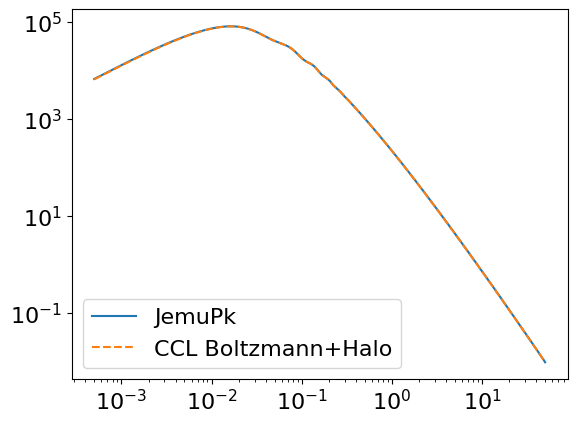

In [149]:
plt.plot(k_star,pk_linear_kstar, label="JemuPk")
plt.plot(k_star,pk_lin_ccl_bc_kstar, label="CCL Boltzmann+Halo", ls="--")
plt.yscale("log")
plt.xscale("log")
plt.legend();